In [75]:
# !pip install pandas --upgrade  --quiet
# !pip install numpy --upgrade  --quiet
# !pip install scipy --upgrade  --quiet
# !pip install statsmodels --upgrade  --quiet
# !pip install scikit-learn --upgrade  --quiet
# !pip install missingno --upgrade  --quiet
!pip install apafib --upgrade --quiet

Objetivos de aprendizaje:
1. Hacer un mínimo análisis exploratorio de un conjunto de datos
2. Hacer el preproceso de un conjunto de datos para usar regresión
3. Saber plantear problemas de regresión sencillos y resolverlos usando diferentes
métodos
4. Interpretar los resultados de un problema de regresión

# Problema 2: Barcelona motor del IBEX
La predicción bursátil es un problema complejo, pero a veces se pueden observar relaciones con variables que aparentemente no deberían influenciar. El portal de datos abiertos del ayuntamiento de Barcelona recoge informaciones diarias sobre la ciudad y esto nos ofrece la oportunidad de averiguar si lo que pasa en Barcelona tiene alguna influencia en el mercado del IBEX. Vamos a trabajar con un extracto de esos datos para el año 2021, con un subconjunto de variables que hemos elegido según nuestro criterio experto para desentrañar esa influencia. El objetivo es aproximar el valor de la cotización del IBEX a partir de las otras variables. Puedes obtener estos datos mediante la función load_BCN_IBEX de la librería apafib.

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot
import statsmodels.api as sm

from apafib import load_BCN_IBEX

ibex = load_BCN_IBEX()
ibex.head()

,Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges,Dades meteorològiques: Precipitació / Barcelona - Zona Universitària,Dades meteorològiques: Temperatura / Barcelona - Zona Universitària,Dades meteorològiques: Vent / Barcelona - Zona Universitària,Estat del trànsit segons trams horaris / Matí (6-13),Estat del trànsit segons trams horaris / Nit (0-5),Estat del trànsit segons trams horaris / Tarda (14-19),Estat del trànsit segons trams horaris / Vespre (20-24),IPC interanual / Barcelona,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa,Preu electricitat (majorista) /,Matriculacions de vehicles a Barcelona / Turismes,Mercat bursàtil: IBEX-35 /
0,115.0,0.0,8.01,5.61,1.3315,1.1320,1.3569,1.2932,0.5,3.0,82.0,64.0,42.510000,0.0,8079.0
1,115.0,0.0,5.96,6.51,1.5194,1.3092,1.5811,1.3750,0.5,3.0,106.0,87.0,48.720417,0.0,8079.0
2,115.0,0.0,5.31,5.52,1.3979,1.1893,1.4745,1.3311,0.5,2.0,138.0,134.0,46.927500,0.0,8079.0
3,115.0,0.0,5.72,5.13,1.8664,1.2005,1.9598,1.5096,0.5,3.0,149.0,114.0,59.849583,21.0,8079.0
4,115.0,0.0,5.23,4.25,1.8802,1.2213,1.9231,1.4455,0.5,1.0,103.0,81.0,67.545417,54.0,8062.9


## a)
### Divide el conjunto de datos en entrenamiento y test (80 %/20 %).

In [77]:
ibex_train, ibex_test = train_test_split(ibex, test_size = 0.2, random_state = 22)

print("Hemos dividido el conjunto de datos en entrenamento y test (80/20 %")
print("-"*67)
print(f"Mida conjunt entrenament: {ibex_train.shape}")
print(f"Mida conjunt test: {ibex_test.shape}")

Hemos dividido el conjunto de datos en entrenamento y test (80/20 %
-------------------------------------------------------------------
Mida conjunt entrenament: (292, 15)
Mida conjunt test: (73, 15)


### Comprobamos los valores faltantes
Primero de todo, debemos mirar si existe algun valor vacío, ya que debemos lidiar con ellos primero.

In [78]:
print("Valores nulos:")
print(ibex_train.isna().sum())

Valores nulos:
Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges                  0
Dades meteorològiques: Precipitació / Barcelona - Zona Universitària                          0
Dades meteorològiques: Temperatura / Barcelona - Zona Universitària                           0
Dades meteorològiques: Vent / Barcelona - Zona Universitària                                  0
Estat del trànsit segons trams horaris / Matí (6-13)                                          0
Estat del trànsit segons trams horaris / Nit (0-5)                                            0
Estat del trànsit segons trams horaris / Tarda (14-19)                                        0
Estat del trànsit segons trams horaris / Vespre (20-24)                                       0
IPC interanual / Barcelona                                                                    0
Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica    0
Operacions d'aeronaus a l

Podemos ver que no tenemos valores faltantes, así que no nos tenemos que preocupar de tratarlos.

### Haz una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Describe las cosas que hayas visto que te parezcan interesantes.

In [79]:
ibex_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 41 to 132
Data columns (total 15 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges                292 non-null    float64
 1   Dades meteorològiques: Precipitació / Barcelona - Zona Universitària                        292 non-null    float64
 2   Dades meteorològiques: Temperatura / Barcelona - Zona Universitària                         292 non-null    float64
 3   Dades meteorològiques: Vent / Barcelona - Zona Universitària                                292 non-null    float64
 4   Estat del trànsit segons trams horaris / Matí (6-13)                                        292 non-null    float64
 5   Estat del trànsit segons trams horaris / Nit (0

Podemos ver que todas nuestras variables son numéricas. A continuación veremos una descripción estadística de los datos del conjunto de entrenamiento de estas variables, y luego realizaremos un estudio de las relaciones entre ellas, en especial con la variable objetivo.

In [80]:
print('Descripción estadística de las variables numéricas (todas):')
ibex_train.describe()

Descripción estadística de las variables numéricas (todas):


,Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges,Dades meteorològiques: Precipitació / Barcelona - Zona Universitària,Dades meteorològiques: Temperatura / Barcelona - Zona Universitària,Dades meteorològiques: Vent / Barcelona - Zona Universitària,Estat del trànsit segons trams horaris / Matí (6-13),Estat del trànsit segons trams horaris / Nit (0-5),Estat del trànsit segons trams horaris / Tarda (14-19),Estat del trànsit segons trams horaris / Vespre (20-24),IPC interanual / Barcelona,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa,Preu electricitat (majorista) /,Matriculacions de vehicles a Barcelona / Turismes,Mercat bursàtil: IBEX-35 /
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,262.904110,0.752397,17.247911,4.643356,1.863700,1.232799,1.938855,1.553128,2.671575,6.123288,170.900685,220.260274,110.026467,58.643836,8678.589041
std,98.172569,2.986941,6.003986,1.741411,0.228490,0.061806,0.253587,0.156489,1.717060,4.273133,76.554769,137.043453,72.559225,37.734693,353.787261
min,27.000000,0.000000,4.640000,1.790000,1.317400,1.132000,1.272600,1.230400,-0.100000,1.000000,31.000000,28.000000,1.419583,0.000000,7750.200000
25%,213.000000,0.000000,12.367500,3.457500,1.660825,1.192850,1.740825,1.476675,1.200000,2.000000,89.500000,76.500000,61.087812,35.750000,8386.300000
50%,268.000000,0.000000,16.465000,4.345000,1.963050,1.219550,1.996850,1.533500,2.300000,5.000000,191.500000,226.000000,86.622292,51.000000,8753.950000
75%,335.000000,0.000000,23.512500,5.432500,2.037750,1.253875,2.145800,1.610000,3.500000,10.000000,242.250000,353.000000,152.597187,69.250000,8958.175000
max,491.000000,24.500000,28.660000,12.730000,2.289700,1.491600,2.370900,2.238000,5.800000,17.000000,284.000000,445.000000,383.672500,231.000000,9289.900000


Con esta breve descripción de las variables numéricas, podemos ver que la variable $Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges$ tiene una std bastante elevada respecto a su media, y aunque la mediana este bastante cerca de la media vemos que hay outliers debido a los valores min y max. Vemos también que la mayoría (> 75%) de valores de la variable $Dades meteorològiques: Precipitació / Barcelona - Zona Universitària$ tiene valor 0. Observamos también que la variable $IPC interanual / Barcelona$ es la única con algún valor negativo. Finalmente vemos que además de la variable mencionada antes, tanto $Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya$ como $Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa$ como $Preu electricitat (majorista) /$ como $Matriculacions de vehicles a Barcelona / Turismes$ tienen una std muy elevada con respecto a sus medias respectivas. La variable objetivo es la que tiene mayor std en valor absoluto, aunque si lo comparamos con la media de valores de la variable no es tan elevada como la de las variables destacadas anteriormente.

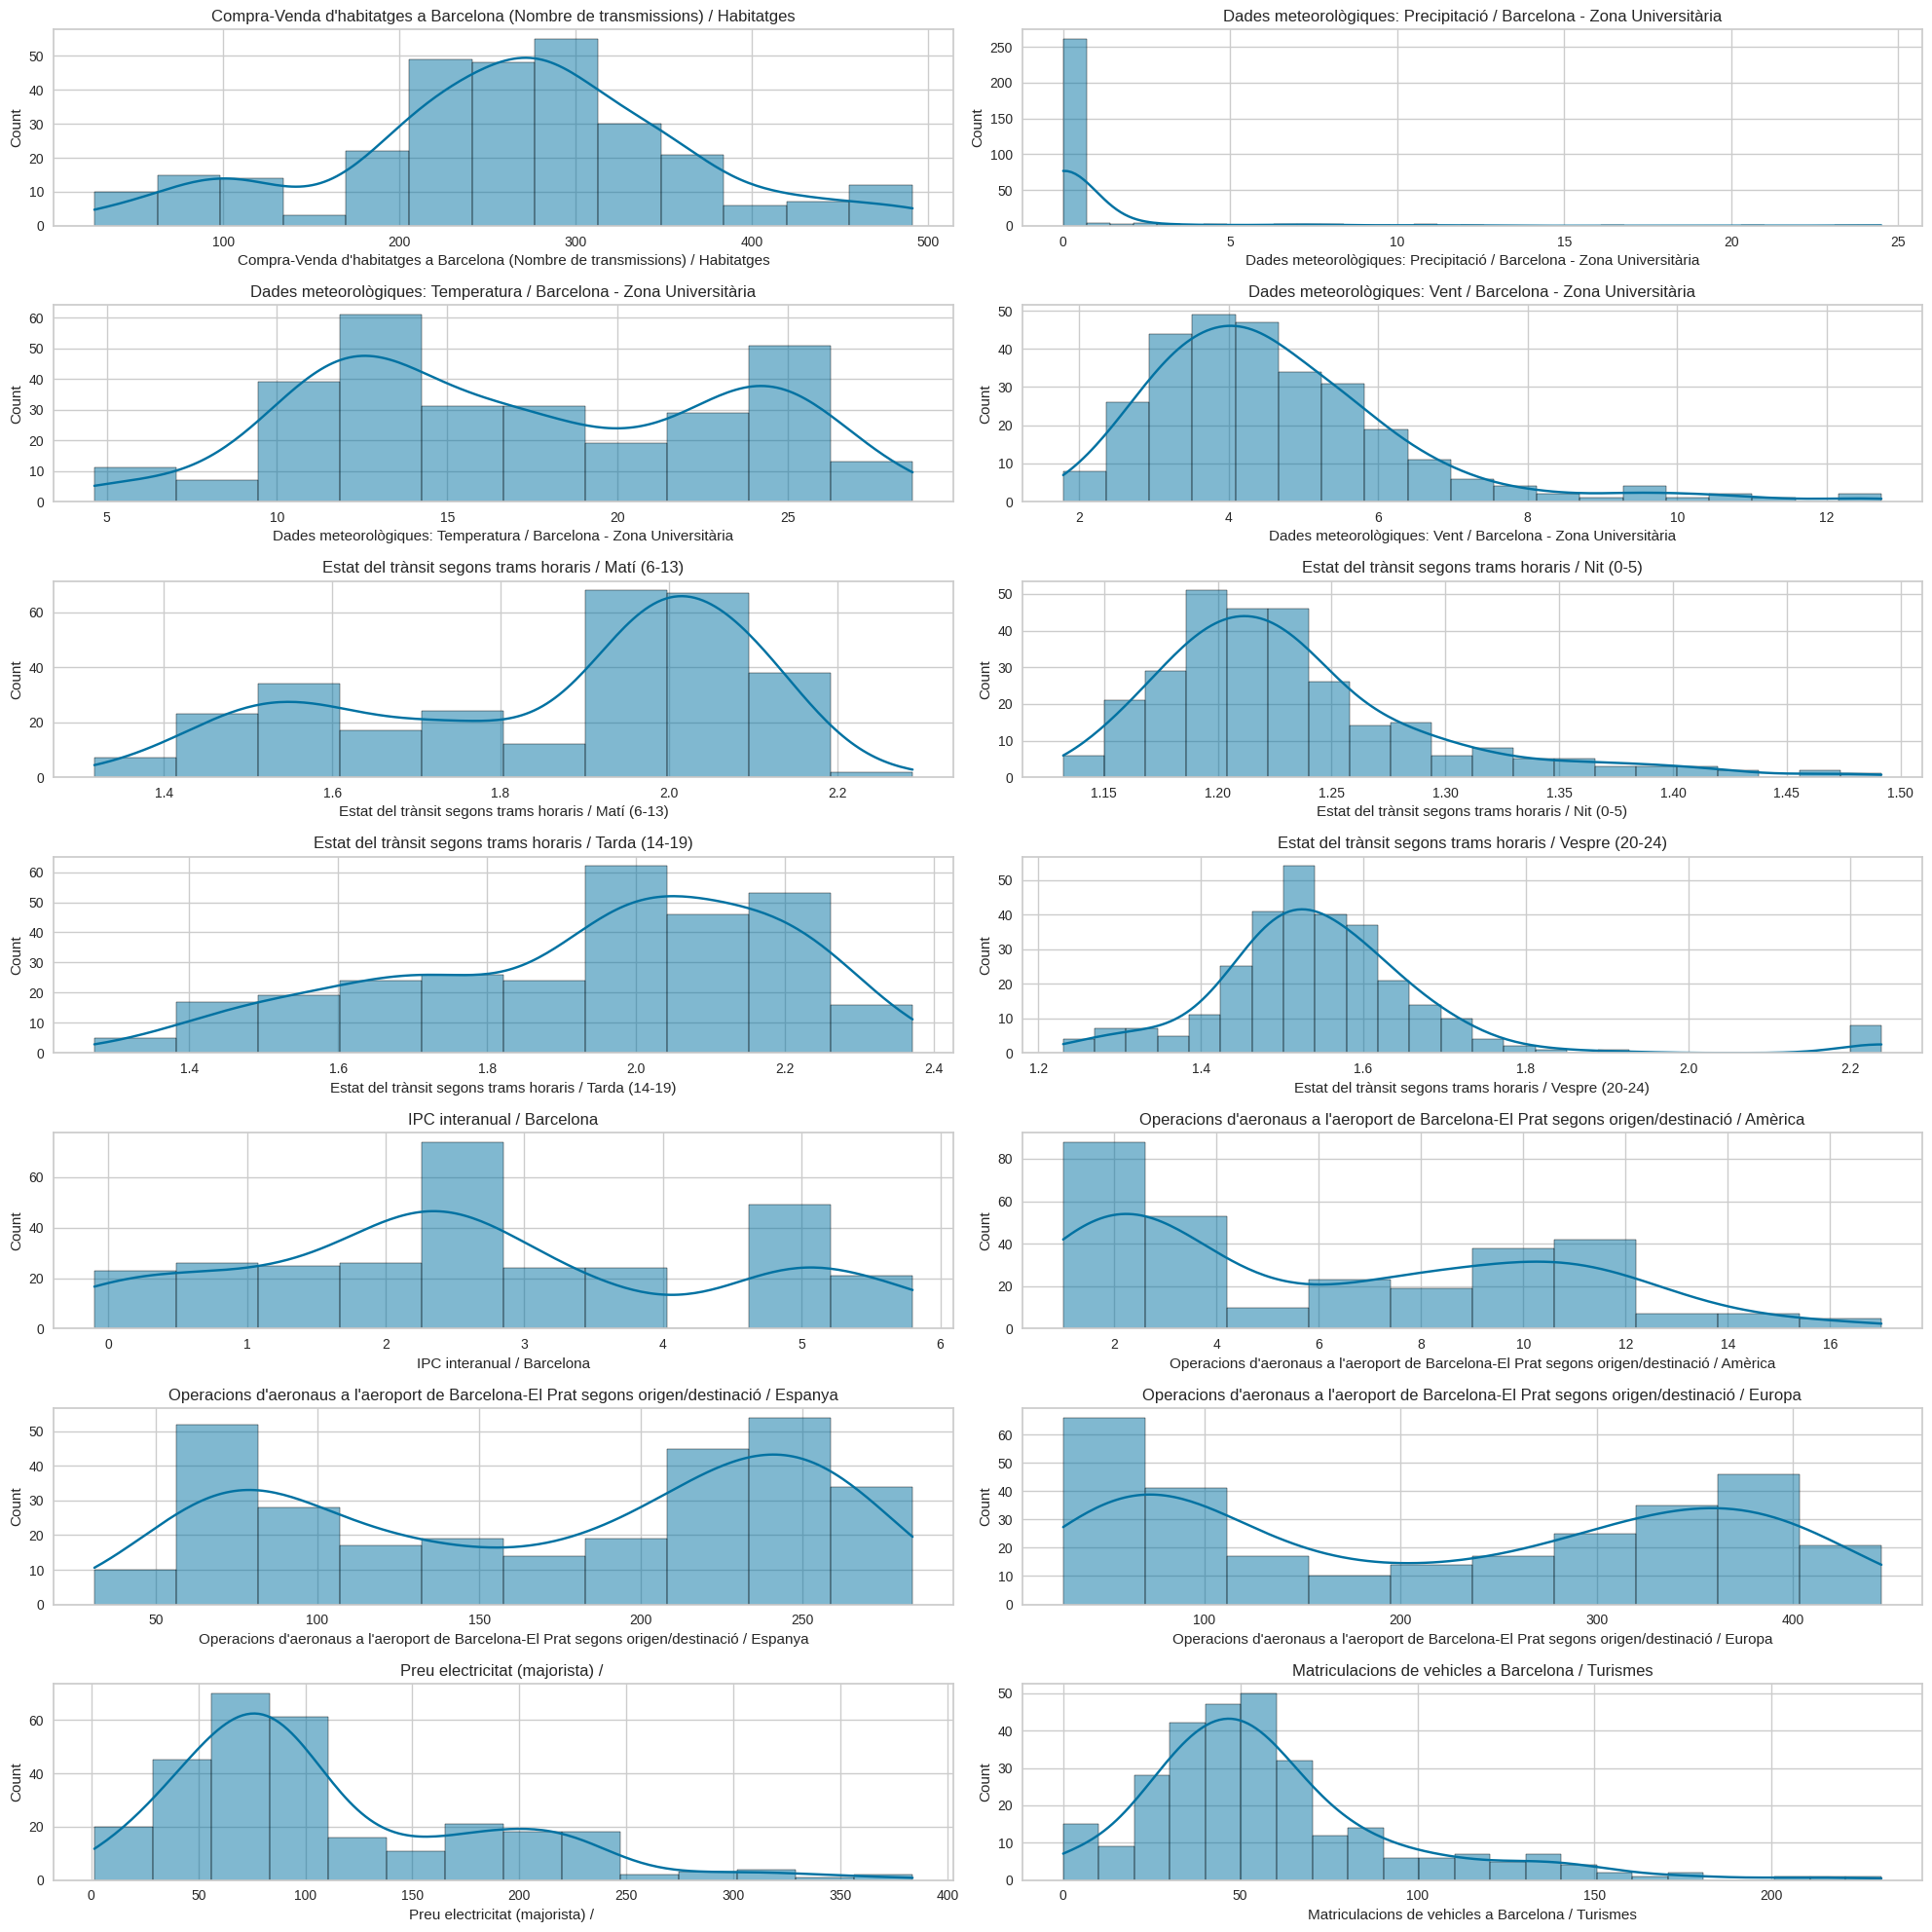

In [81]:
fig, axes = plt.subplots(7, 2, figsize = (20, 20))
axes = axes.ravel()
for i, col in enumerate(["Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges", 'Dades meteorològiques: Precipitació / Barcelona - Zona Universitària', 'Dades meteorològiques: Temperatura / Barcelona - Zona Universitària', 'Dades meteorològiques: Vent / Barcelona - Zona Universitària', 'Estat del trànsit segons trams horaris / Matí (6-13)', 'Estat del trànsit segons trams horaris / Nit (0-5)', 'Estat del trànsit segons trams horaris / Tarda (14-19)', 'Estat del trànsit segons trams horaris / Vespre (20-24)', 'IPC interanual / Barcelona', "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica", "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya", "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa", 'Preu electricitat (majorista) / ', 'Matriculacions de vehicles a Barcelona / Turismes']):
    ax = axes[i]
    sns.histplot(ibex_train[col], kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

Con estos histogramas podemos ver las distribuciones de las variables. Mirando sus nombres, vemos que hay variables que miden lo mismo pero en distintas franjas horarias (en el caso de tráfico) o con distintos orígenes/destinos (en caso de operaciones del aeropuerto. Mirando los gráficos, podemos ver que el estado del tránsito sigue distribuciones similares según sí es de día o de noche: la variable que mide el tránsito druante las 6-13h y la que lo mide durante las 14-19h siguen distribuciones muy parecidas. De misma forma, las variables que miden el tránsito durante las 0-5h y durante 20-24h siguen distribuciones muy parecidas. Podemos ver también que las tres variables que miden las operaciones de aeronaves al aeropuerto según origen/destino (América, España y Europa) siguen distribuciones muy parecidas. Finalmente, destacar también que tal y como hemos dicho antes, la mayoría de datos de la variable que mide la precipitación en Barcelona valen 0.

A continuación, realizaremos un estudio de las variables del conjunto de datos de entrenamiento, para ver primero las relaciones de cada variable con la variable objetivo $Mercat bursàtil: IBEX-35$, y luego veremos la matriz de correlaciones.

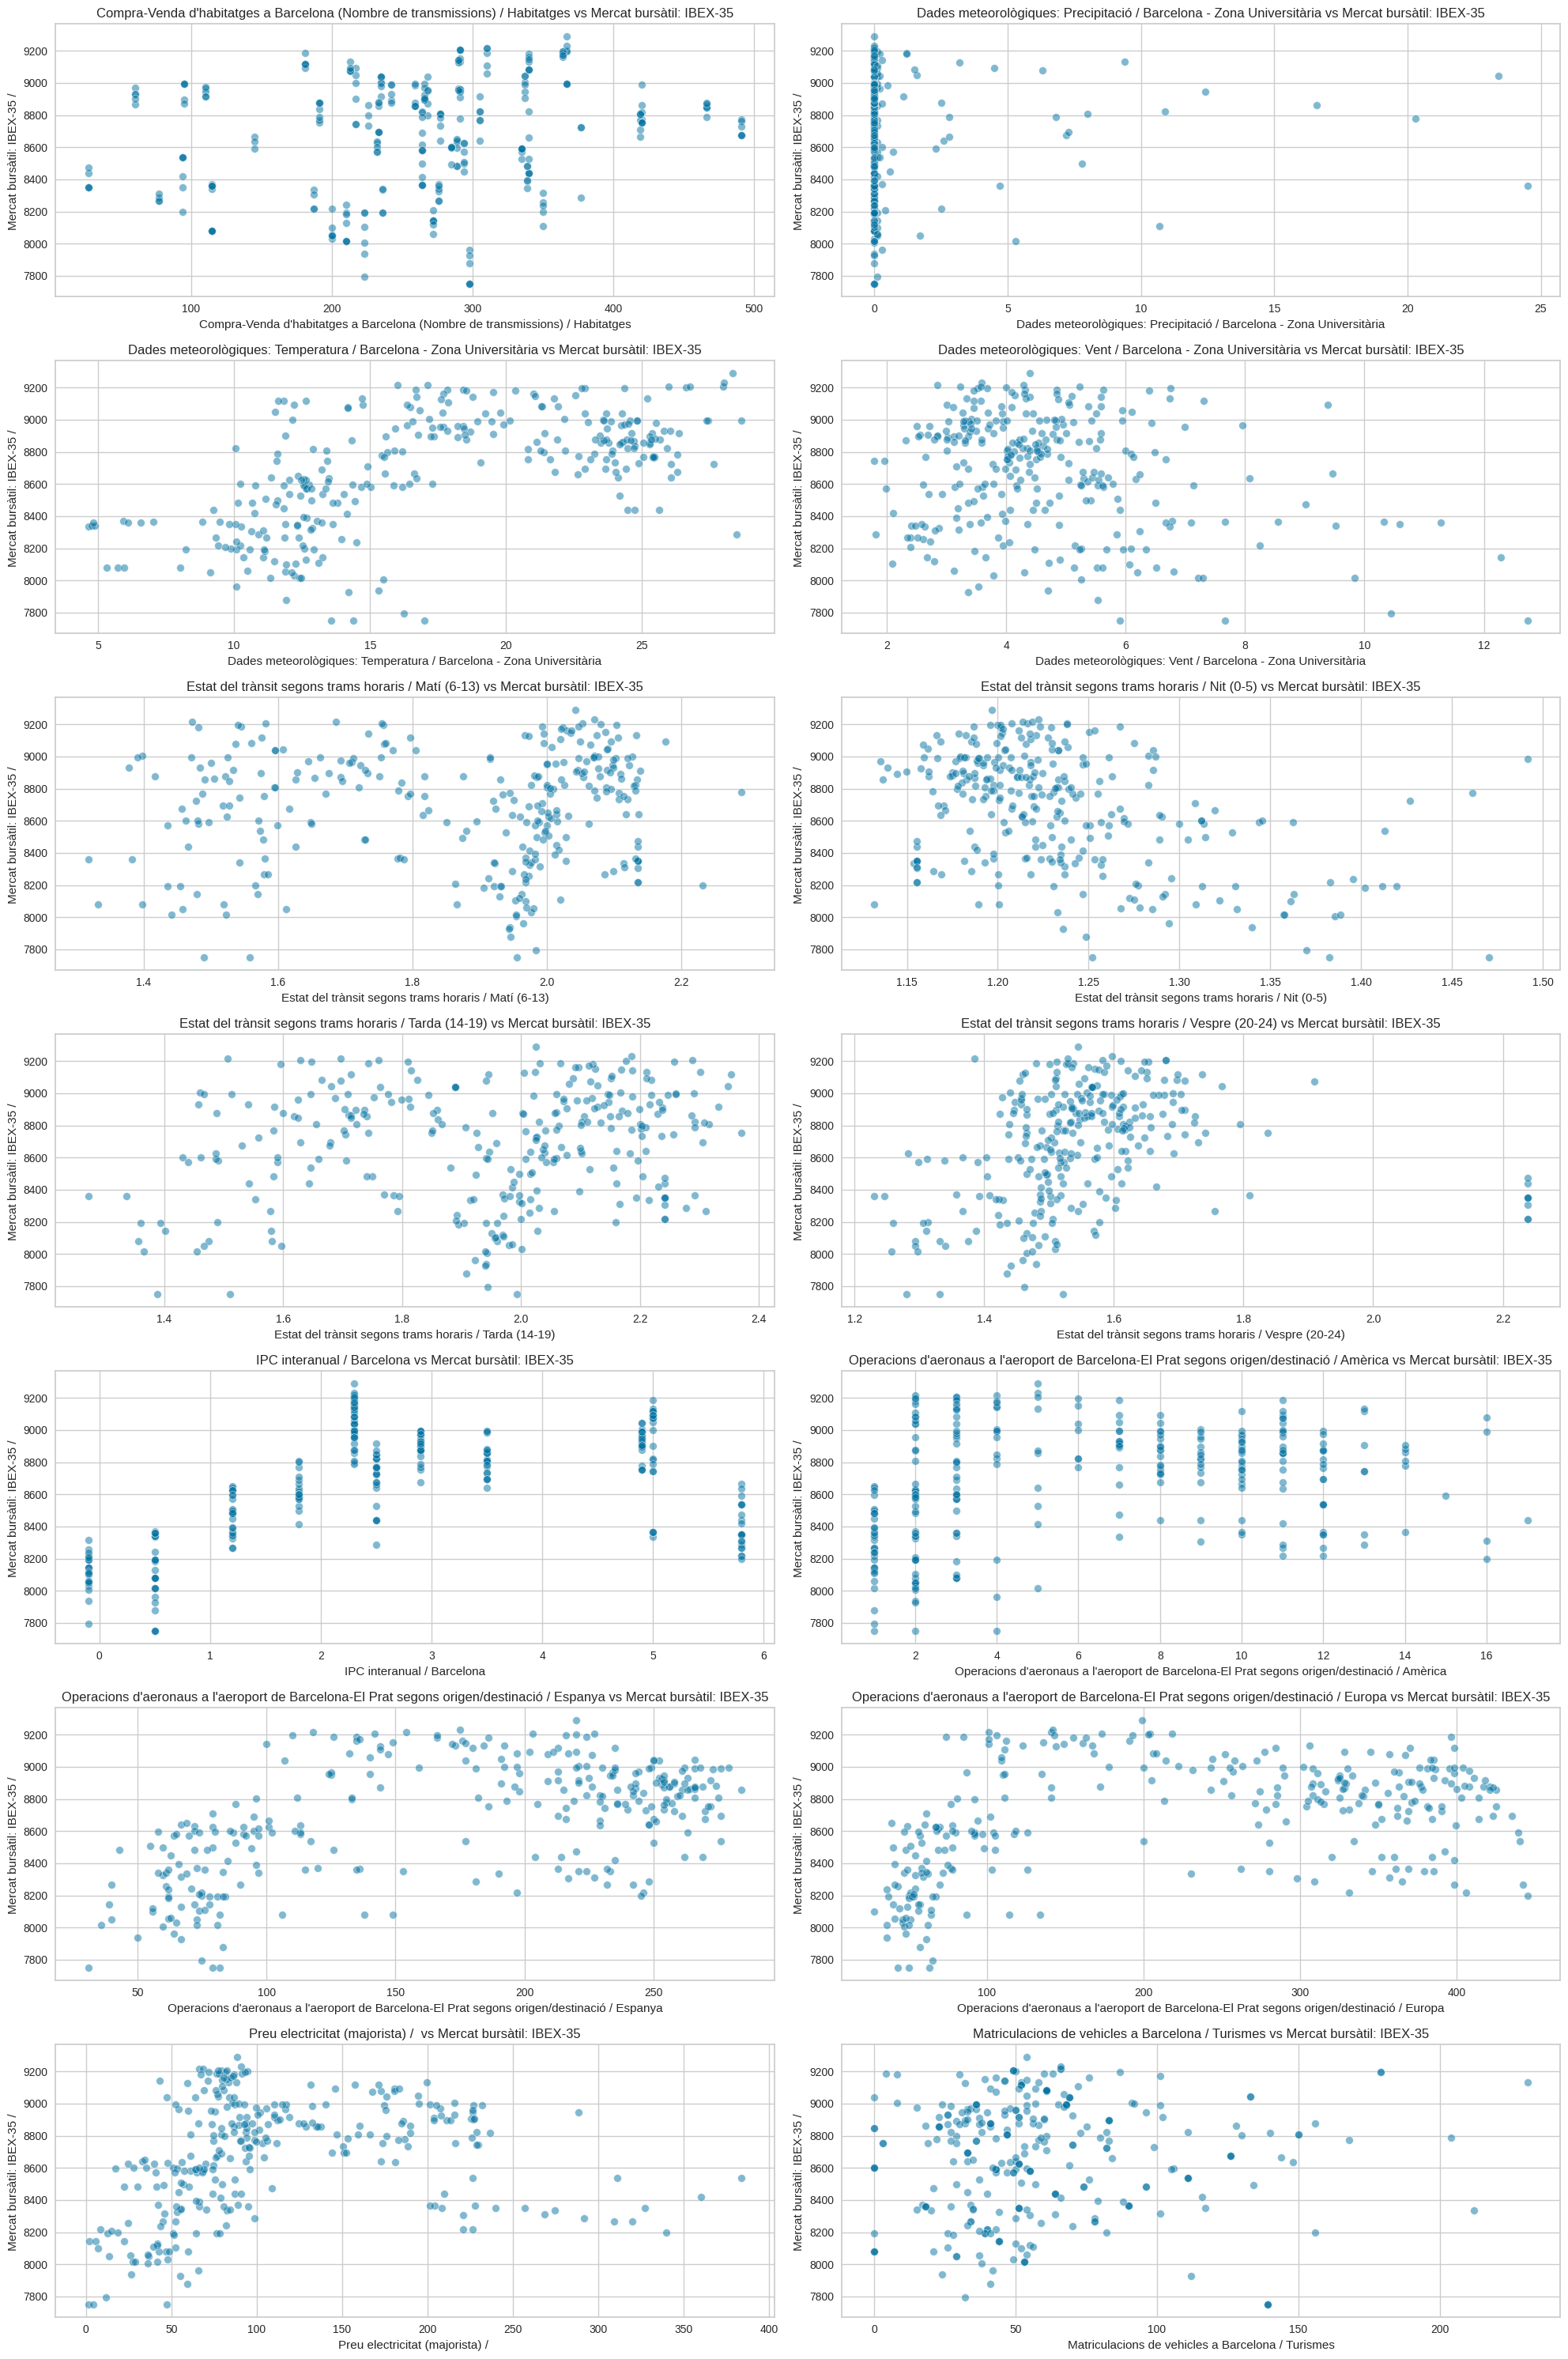

In [82]:
fig, axes = plt.subplots(7, 2, figsize = (20, 30))
axes = axes.ravel()
for i, col in enumerate(["Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges", 'Dades meteorològiques: Precipitació / Barcelona - Zona Universitària', 'Dades meteorològiques: Temperatura / Barcelona - Zona Universitària', 'Dades meteorològiques: Vent / Barcelona - Zona Universitària', 'Estat del trànsit segons trams horaris / Matí (6-13)', 'Estat del trànsit segons trams horaris / Nit (0-5)', 'Estat del trànsit segons trams horaris / Tarda (14-19)', 'Estat del trànsit segons trams horaris / Vespre (20-24)', 'IPC interanual / Barcelona', "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica", "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya", "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa", 'Preu electricitat (majorista) / ', 'Matriculacions de vehicles a Barcelona / Turismes']):
    ax = axes[i]
    sns.scatterplot(x = ibex_train[col], y = ibex_train['Mercat bursàtil: IBEX-35 / '], data = ibex_train, ax = axes[i], alpha = 0.5)
    ax.set_title(col + ' vs Mercat bursàtil: IBEX-35')
plt.tight_layout()
plt.show()

A simple vista, no parece que haya muchas variables con correlación visible con la variable objetivo ($Mercat bursàtil: IBEX-35$) según los gráficos, excepto quizas con las variable $IPC interanual / Barcelona$ y $Dades meteorològiques: Temperatura / Barcelona - Zona Universitària$. Sin embargo, para poder entender mejor las relaciones de las variables con la variable objetivo $Mercat bursàtil: IBEX-35$ (y con el resto de variables) vamos a ver la matriz de correlaciones para ver los grados de correlación.

,Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges,Dades meteorològiques: Precipitació / Barcelona - Zona Universitària,Dades meteorològiques: Temperatura / Barcelona - Zona Universitària,Dades meteorològiques: Vent / Barcelona - Zona Universitària,Estat del trànsit segons trams horaris / Matí (6-13),Estat del trànsit segons trams horaris / Nit (0-5),Estat del trànsit segons trams horaris / Tarda (14-19),Estat del trànsit segons trams horaris / Vespre (20-24),IPC interanual / Barcelona,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa,Preu electricitat (majorista) /,Matriculacions de vehicles a Barcelona / Turismes,Mercat bursàtil: IBEX-35 /
Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges,1.000000,0.000913,0.295531,-0.058940,0.152394,0.176003,0.141038,-0.060461,-0.234459,-0.276087,-0.061386,-0.208172,-0.294917,0.284799,0.209654
Dades meteorològiques: Precipitació / Barcelona - Zona Universitària,0.000913,1.000000,-0.073949,0.114296,0.052713,-0.014403,0.054540,-0.018539,0.055978,0.084194,0.050663,0.069021,0.078511,0.025783,0.035014
Dades meteorològiques: Temperatura / Barcelona - Zona Universitària,0.295531,-0.073949,1.000000,-0.156219,-0.074558,-0.216938,0.017496,0.128399,0.179068,0.304064,0.640763,0.512733,0.008879,0.041200,0.610348
Dades meteorològiques: Vent / Barcelona - Zona Universitària,-0.058940,0.114296,-0.156219,1.000000,-0.095722,0.167110,-0.140685,-0.042624,-0.114799,-0.103085,-0.136587,-0.123129,-0.215510,-0.051203,-0.236765
Estat del trànsit segons trams horaris / Matí (6-13),0.152394,0.052713,-0.074558,-0.095722,1.000000,-0.218192,0.957142,0.522822,0.229381,0.042493,0.100419,0.010753,0.319805,0.163025,0.062855
Estat del trànsit segons trams horaris / Nit (0-5),0.176003,-0.014403,-0.216938,0.167110,-0.218192,1.000000,-0.316669,-0.405437,-0.586470,-0.466919,-0.536362,-0.530951,-0.525012,-0.025953,-0.413426
Estat del trànsit segons trams horaris / Tarda (14-19),0.141038,0.054540,0.017496,-0.140685,0.957142,-0.316669,1.000000,0.617287,0.369779,0.169374,0.262998,0.173248,0.428936,0.200294,0.184063
Estat del trànsit segons trams horaris / Vespre (20-24),-0.060461,-0.018539,0.128399,-0.042624,0.522822,-0.405437,0.617287,1.000000,0.563602,0.389293,0.398568,0.415465,0.490003,0.081339,0.199040
IPC interanual / Barcelona,-0.234459,0.055978,0.179068,-0.114799,0.229381,-0.586470,0.369779,0.563602,1.000000,0.819304,0.726001,0.802705,0.882103,0.160684,0.451096
Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica,-0.276087,0.084194,0.304064,-0.103085,0.042493,-0.466919,0.169374,0.389293,0.819304,1.000000,0.780482,0.892211,0.753784,0.053659,0.293776


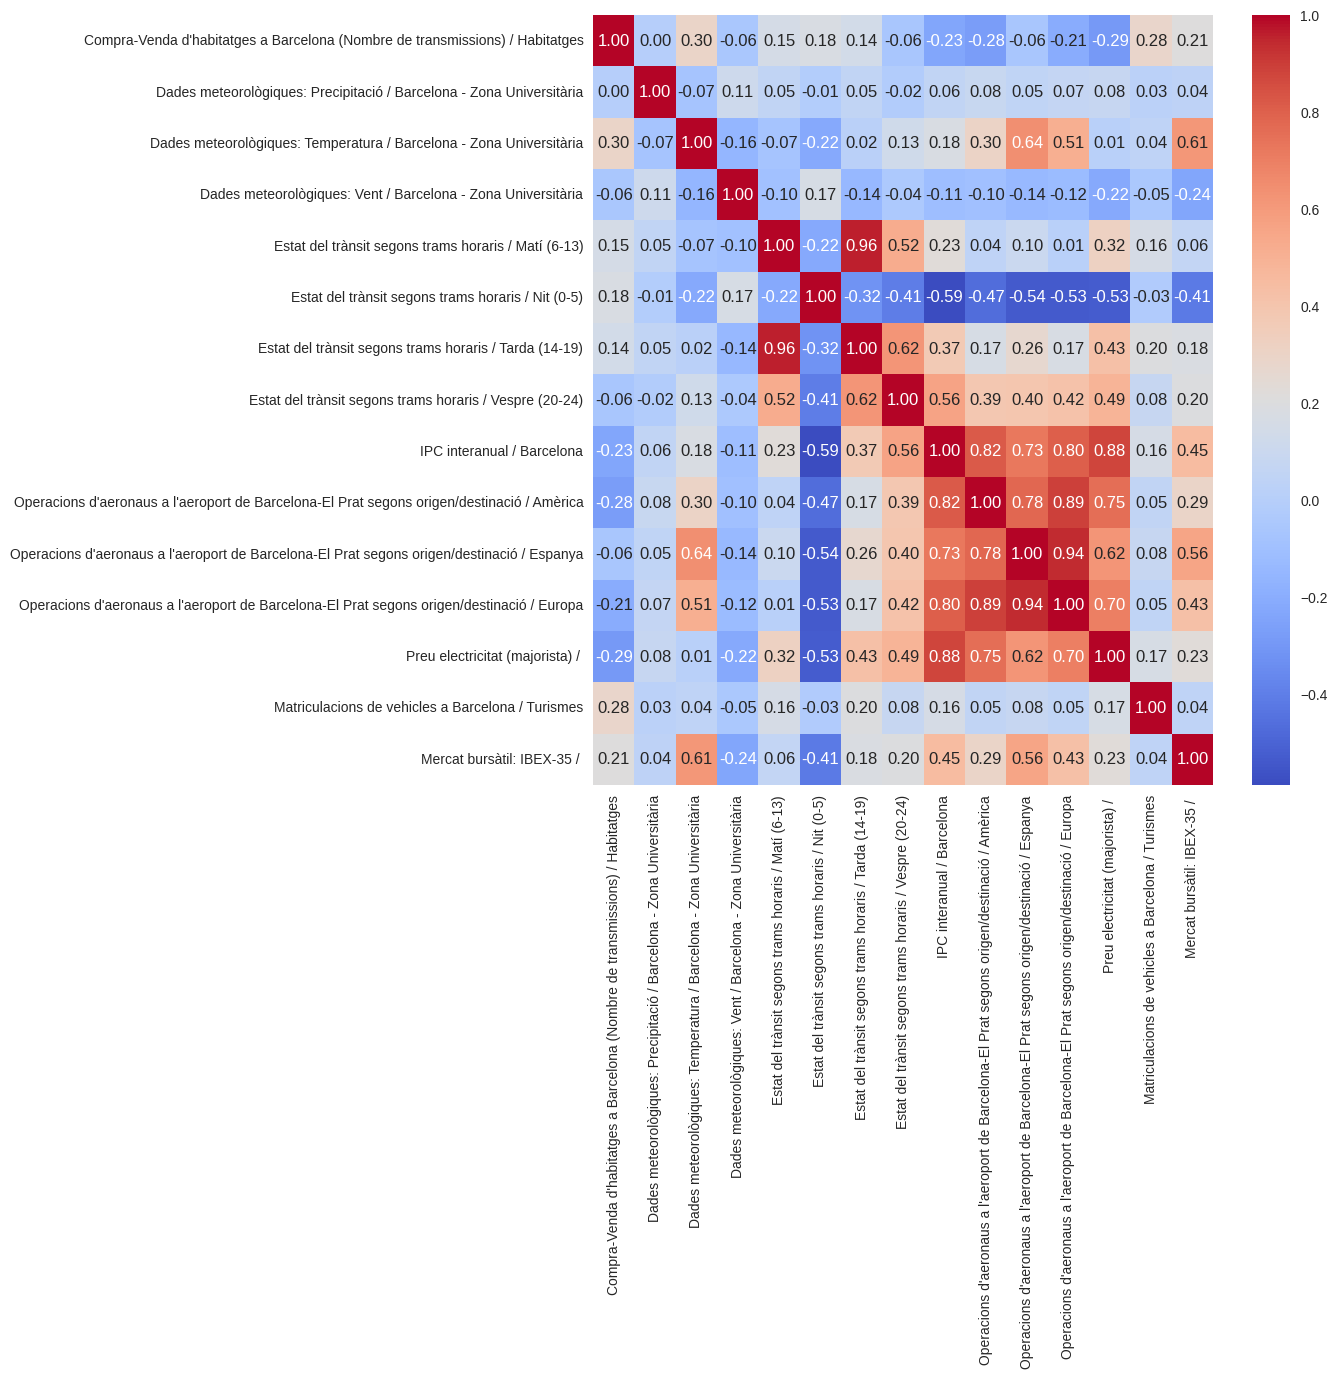

In [83]:
num_cols = ["Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges", 'Dades meteorològiques: Precipitació / Barcelona - Zona Universitària', 'Dades meteorològiques: Temperatura / Barcelona - Zona Universitària', 'Dades meteorològiques: Vent / Barcelona - Zona Universitària', 'Estat del trànsit segons trams horaris / Matí (6-13)', 'Estat del trànsit segons trams horaris / Nit (0-5)', 'Estat del trànsit segons trams horaris / Tarda (14-19)', 'Estat del trànsit segons trams horaris / Vespre (20-24)', 'IPC interanual / Barcelona', "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica", "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya", "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa", 'Preu electricitat (majorista) / ', 'Matriculacions de vehicles a Barcelona / Turismes', 'Mercat bursàtil: IBEX-35 / ']
corr = ibex_train[num_cols].corr()
display(corr)
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt = ".2f", cmap = 'coolwarm')
plt.show()

Podemos ver que en efecto hay mucha relación entre las tres variables que miden las operaciones del aeropuerto. Además, estas tres variables también tienen bastante correlación con el IPC y el precio de la electricidad. Vemos también que las variables que miden el tránsito durante las 6-13h y durante las 14-19h tienen una correlación muy elevada (0.96), aunque no ocurre lo mismo con las variables que miden el tránsito entre las 0-5h y las 20-24h (tambien tienen cierta correlación, pero negativa: -0.4). Cabe destacar que la variable que mide el transito durante las 0-5h tiene bastantes correlaciones negativas (de más o menos -0.4). Además, podemos ver que la variable temperatura tiene correlación con las operaciones del aeropuerto (sobretodo aquellas con origen/destino Español o Europeo). Hay cuatro variables que destacan por tener una correlación mayor que el resto (aprox 0.5) con la variable objetivo: $Dades meteorològiques: Temperatura / Barcelona - Zona Universitària$, $IPC interanual / Barcelona$, $Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya$, $Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa$; y hay una variable con correlación negativa pero también elevada con la variable objetivo: $Estat del trànsit segons trams horaris / Nit (0-5)$.

### Transforma las variables adecuadamente para poder ajustar un modelo de regresión tanto para el conjunto de entrenamiento como para el de test.
Antes de aplicar un modelo de regresión, debemos preparar les variables, que en nuestro caso son todas numéricas. Primero separamos la variable objetivo del resto, y a continuación estandarizamos y centramos las variables.

In [84]:
X_train = ibex_train.drop('Mercat bursàtil: IBEX-35 / ', axis = 1)
Y_train = ibex_train['Mercat bursàtil: IBEX-35 / ']
X_test = ibex_test.drop('Mercat bursàtil: IBEX-35 / ', axis = 1)
Y_test = ibex_test['Mercat bursàtil: IBEX-35 / ']

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)   
X_test_std = scaler.transform(X_test)

# Comprobamos que se haya estandarizado bien
print(f"Std (debería ser 1): {X_train_std.std(axis = 0)}")
print(f"Avg (debería ser 0): {X_train_std.mean(axis = 0)}")

Std (debería ser 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Avg (debería ser 0): [ 2.67670209e-16 -3.04170692e-17 -2.00752657e-16 -1.52085346e-17
  8.09094040e-16  1.42656054e-15 -1.33835104e-16 -4.25838968e-16
  4.86673107e-17 -2.43336553e-17  7.30009660e-17  3.65004830e-17
 -1.82502415e-16 -1.21668277e-16]


Vemos que se ha estandarizado correctamente (las medias son casi 0 y las std son 1).
## b)
### Aplica Análisis de Componentes Principales (PCA) adecuadamente al conjunto de entrenamiento y visualízalo en 2D representando la variable objetivo. ¿Crees que puede haber una relación entre las variables del conjunto de datos y la variable objetivo? ¿Por qué?

Componentes necessarias según varianza explicada deseada:
   70%: 4 components (real:  73.66%)
   80%: 5 components (real:  80.70%)
   90%: 7 components (real:  91.07%)


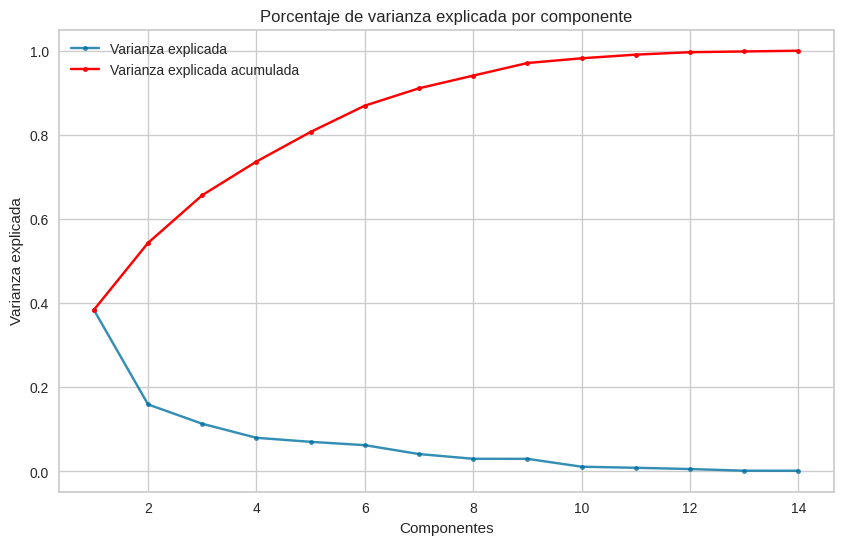

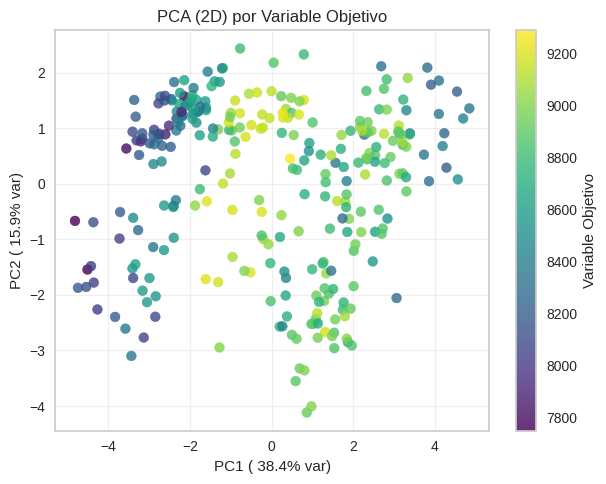

Correlaciones con la Variable Objetivo -> r(PC1, var_obj) =  0.465, r(PC2, var_obj) = -0.103


In [85]:
ibex_PCA = PCA().fit(X_train_std)

# Gráfico de varianza explicada por cada componente
fig = plt.figure(figsize = (10, 6));
plt.plot(range(1, len(ibex_PCA.explained_variance_ratio_ ) + 1), ibex_PCA.explained_variance_ratio_, alpha = 0.8, marker = '.', label = "Varianza explicada");
y_label = plt.ylabel('Varianza explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1, len(ibex_PCA.explained_variance_ratio_ ) + 1), np.cumsum(ibex_PCA.explained_variance_ratio_), c = 'red', marker='.', label = "Varianza explicada acumulada");
plt.legend();
plt.title('Porcentaje de varianza explicada por componente');

# Número de componentes según umbrales
umbral = [0.70, 0.80, 0.90]
cumsum = np.cumsum(ibex_PCA.explained_variance_ratio_)
print("Componentes necessarias según varianza explicada deseada:")
for u in umbral:
    comp = np.argmax(cumsum >= u) + 1
    var_exp = cumsum[comp - 1]
    print(f"  {u*100: .0f}%: {comp} components (real: {var_exp*100: .2f}%)")

# Visualizamos en 2D
ibex_PCA_2d = PCA(n_components = 2, random_state = 22)
Z_train = ibex_PCA_2d.fit_transform(X_train_std)
Z_test  = ibex_PCA_2d.transform(X_test_std)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(Z_train[:, 0], Z_train[:, 1], c = Y_train, cmap = 'viridis', s = 50, alpha = 0.8)
plt.xlabel(f"PC1 ({ibex_PCA_2d.explained_variance_ratio_[0]*100: .1f}% var)")
plt.ylabel(f"PC2 ({ibex_PCA_2d.explained_variance_ratio_[1]*100: .1f}% var)")
plt.title("PCA (2D) por Variable Objetivo")
plt.colorbar(scatter, label = "Variable Objetivo")
plt.grid(True, alpha = 0.3)
plt.tight_layout();
plt.show()

# Correlaciones
r_obj_pc1 = np.corrcoef(Z_train[:, 0], Y_train)[0, 1]
r_obj_pc2 = np.corrcoef(Z_train[:, 1], Y_train)[0, 1]
print(f"Correlaciones con la Variable Objetivo -> r(PC1, var_obj) = {r_obj_pc1: .3f}, r(PC2, var_obj) = {r_obj_pc2: .3f}")

Con 2 componentes solo podemos explicar el 55% de la varianza aproximadamente. Aunque solo podamos representar el 55% de la varianza en 2D, es suficiente como para poder constituir una buena representación de la variable objetivo. Podemos ver una clara diferenciación de colores en el eje X (PC1), por lo que sí puede haber relación entre las variables del conjunto de datos y la variable objetivo. Vemos que hay una correlación de 0.465 entre la variable objetivo y PC1, lo que explica la diferenciación de colores en el eje X, sin embargo casi no hay correlación con PC2, lo que indica que igual no hay una relación muy fuerte entre las variables del conjunto de datos y la variable objetivo.

## c)
### Ajusta una regresión lineal, una regresión Ridge y una regresión LASSO a los datos ¿Te parece suficientemente bueno el resultado? ¿Qué modelo te parece mejor? 

In [86]:
# Linear regression
lr = LinearRegression()
lr.fit(X_train_std, Y_train)
y_pred_train_lr = lr.predict(X_train_std)
y_pred_test_lr = lr.predict(X_test_std)
r2_train_lr = r2_score(Y_train, y_pred_train_lr)
r2_test_lr = r2_score(Y_test, y_pred_test_lr)
print(f"Linear R2 Train: {r2_train_lr: .4f}")
print(f"Linear R2 Test: {r2_test_lr: .4f}")

# Ridge regression
lambdas_ridge = [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10, 50, 100]
ridge_cv = RidgeCV(alphas = lambdas_ridge, cv = 5, scoring = 'r2').fit(X_train_std, Y_train)
y_pred_train_ridge = ridge_cv.predict(X_train_std)
y_pred_test_ridge = ridge_cv.predict(X_test_std)
r2_train_ridge = r2_score(Y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(Y_test, y_pred_test_ridge)
print(f'Ridge Mejor lambda: {ridge_cv.alpha_}')
print(f'Ridge R2 Train: {r2_train_ridge:.4f}')
print(f'Ridge R2 Test: {r2_test_ridge:.4f}')
print(f'Ridge R2 CV Score: {ridge_cv.best_score_:.4f}')

# Lasso regression
lambdas_lasso = np.logspace(-3, 1, 50)
lasso_cv = LassoCV(alphas = lambdas_lasso, cv = 5, random_state = 22).fit(X_train_std, Y_train)
y_pred_train_lasso = lasso_cv.predict(X_train_std)
y_pred_test_lasso = lasso_cv.predict(X_test_std)
r2_train_lasso = r2_score(Y_train, y_pred_train_lasso)
r2_test_lasso = r2_score(Y_test, y_pred_test_lasso)
lasso_cv_scores = cross_val_score(lasso_cv, X_train_std, Y_train, cv=5, scoring='r2')
print(f'Lasso Mejor lambda: {lasso_cv.alpha_:.4f}')
print(f'Lasso R2 Train: {r2_train_lasso:.4f}')
print(f'Lasso R2 Test: {r2_test_lasso:.4f}')
print(f'Lasso R2 CV Score: {np.mean(lasso_cv_scores):.4f}')

Linear R2 Train:  0.7327
Linear R2 Test:  0.5296
Ridge Mejor lambda: 1.0
Ridge R2 Train: 0.7317
Ridge R2 Test: 0.5423
Ridge R2 CV Score: 0.6911
Lasso Mejor lambda: 0.3393
Lasso R2 Train: 0.7325
Lasso R2 Test: 0.5349
Lasso R2 CV Score: 0.6898


No me parece suficientemente buen resultado ya que en los valores de test solo obtenemos un valor de R2 de aprox 52%. Tanto Ridge como Lasso estan haciendo overfitting ya que CV Score es mayor que R2 Test en ambos casos. El modelo que me parece mejor es Ridge, ya que tiene mayor valor de R2 para test, menor diferencia entre R2 Train y R2 Test, y tiene un buen valor de CV.

### Representa los residuos de la mejor regresión y los valores de la variable objetivo del conjunto de test contra sus predicciones. ¿Tienen sentido las variables con más peso que aparecen en los modelos para la variable que queremos predecir?

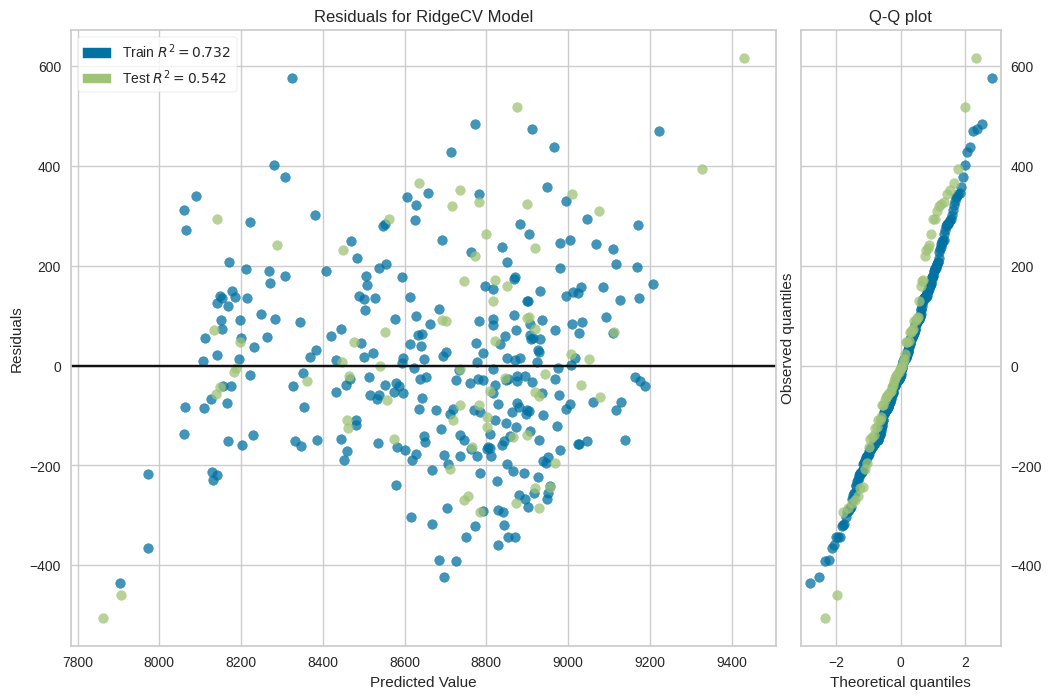

VARIABLES MÁS IMPORTANTES EN RIDGE:
                                             Variable  Coeficiente  \
8                          IPC interanual / Barcelona   416.425681   
11  Operacions d'aeronaus a l'aeroport de Barcelon...  -344.936862   
10  Operacions d'aeronaus a l'aeroport de Barcelon...   220.585235   
2   Dades meteorològiques: Temperatura / Barcelona...   169.249694   
12                   Preu electricitat (majorista) /   -157.530659   
6   Estat del trànsit segons trams horaris / Tarda...   144.865018   
4   Estat del trànsit segons trams horaris / Matí ...  -144.634389   
7   Estat del trànsit segons trams horaris / Vespr...   -61.717127   
3   Dades meteorològiques: Vent / Barcelona - Zona...   -55.100728   
9   Operacions d'aeronaus a l'aeroport de Barcelon...   -49.894576   
5   Estat del trànsit segons trams horaris / Nit (...   -40.570364   
13  Matriculacions de vehicles a Barcelona / Turismes   -38.984965   
1   Dades meteorològiques: Precipitació / Barcelon... 

In [87]:
# Gráfico residuos
ridge_cv = RidgeCV(alphas = [1.0], cv = 5, scoring = 'r2').fit(X_train_std, Y_train)
plt.figure(figsize = (12, 8))
viz = residuals_plot(ridge_cv, X_train_std, Y_train, X_test_std, Y_test, is_fitted = True, qqplot = True, hist = False)

# Variables con más peso en Ridge
feature_importance = pd.DataFrame({
    'Variable': ["Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges", 'Dades meteorològiques: Precipitació / Barcelona - Zona Universitària', 'Dades meteorològiques: Temperatura / Barcelona - Zona Universitària', 'Dades meteorològiques: Vent / Barcelona - Zona Universitària', 'Estat del trànsit segons trams horaris / Matí (6-13)', 'Estat del trànsit segons trams horaris / Nit (0-5)', 'Estat del trànsit segons trams horaris / Tarda (14-19)', 'Estat del trànsit segons trams horaris / Vespre (20-24)', 'IPC interanual / Barcelona', "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica", "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya", "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa", 'Preu electricitat (majorista) / ', 'Matriculacions de vehicles a Barcelona / Turismes'],
    'Coeficiente': ridge_cv.coef_,
    'Abs_Coefficient': np.abs(ridge_cv.coef_)
})
top_variables = feature_importance.sort_values('Abs_Coefficient', ascending = False)
print("VARIABLES MÁS IMPORTANTES EN RIDGE:")
print(top_variables.head(14))

Vemos que las cuatro variables más importantes son las que hemos mencionado anteriormente. Tanto el IPC como operaciones del aeropuerto con origen/destino España o Europa sí tienen sentido así como el precio de la electricidad. Sin embargo la Temperatura no parece tener mucho sentido para predecir el valor del IBEX, y el estado del tránsito tampoco parece tener sentido en cuanto a precedir el valor del IBEX.

### Elimina las variables que tienen menos peso en los modelos del conjunto de datos y reajusta el modelo de regresión lineal ¿Cómo ha cambiado el peso de las variables que quedan?

In [88]:
# Eliminamos las 7 variables con menor peso y estandarizamos
drop_vars = ["Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges", 'Dades meteorològiques: Precipitació / Barcelona - Zona Universitària', 'Dades meteorològiques: Vent / Barcelona - Zona Universitària', 'Estat del trànsit segons trams horaris / Nit (0-5)', 'Estat del trànsit segons trams horaris / Vespre (20-24)', "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica", 'Matriculacions de vehicles a Barcelona / Turismes']
scaler = StandardScaler()
X_train_std_2 = scaler.fit_transform(X_train.drop(drop_vars, axis = 1))   
X_test_std_2 = scaler.transform(X_test.drop(drop_vars, axis = 1))

# Comprobamos que se haya estandarizado bien
print(f"Std (debería ser 1): {X_train_std_2.std(axis = 0)}")
print(f"Avg (debería ser 0): {X_train_std_2.mean(axis = 0)}")

# Linear regression
lr = LinearRegression()
lr.fit(X_train_std_2, Y_train)
y_pred_train_lr = lr.predict(X_train_std_2)
y_pred_test_lr = lr.predict(X_test_std_2)
r2_train_lr = r2_score(Y_train, y_pred_train_lr)
r2_test_lr = r2_score(Y_test, y_pred_test_lr)
print(f"Linear R2 Train: {r2_train_lr: .4f}")
print(f"Linear R2 Test: {r2_test_lr: .4f}")

# Pesos de las variables
feature_importance = pd.DataFrame({
    'Variable': ['Dades meteorològiques: Temperatura / Barcelona - Zona Universitària', 'Estat del trànsit segons trams horaris / Matí (6-13)', 'Estat del trànsit segons trams horaris / Tarda (14-19)', 'IPC interanual / Barcelona', "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya", "Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa", 'Preu electricitat (majorista) / '],
    'Coeficiente': lr.coef_,
    'Abs_Coefficient': np.abs(lr.coef_)
})
top_variables = feature_importance.sort_values('Abs_Coefficient', ascending = False)
print("VARIABLES MÁS IMPORTANTES EN LINEAR REGRESSION:")
print(top_variables.head(14))

Std (debería ser 1): [1. 1. 1. 1. 1. 1. 1.]
Avg (debería ser 0): [-2.00752657e-16  8.09094040e-16 -1.33835104e-16  4.86673107e-17
  7.30009660e-17  3.65004830e-17 -1.82502415e-16]
Linear R2 Train:  0.6639
Linear R2 Test:  0.5779
VARIABLES MÁS IMPORTANTES EN LINEAR REGRESSION:
                                            Variable  Coeficiente  \
5  Operacions d'aeronaus a l'aeroport de Barcelon...  -452.668109   
3                         IPC interanual / Barcelona   373.734506   
4  Operacions d'aeronaus a l'aeroport de Barcelon...   295.116469   
0  Dades meteorològiques: Temperatura / Barcelona...   177.791900   
1  Estat del trànsit segons trams horaris / Matí ...  -167.987496   
2  Estat del trànsit segons trams horaris / Tarda...   138.744805   
6                   Preu electricitat (majorista) /   -124.611684   

   Abs_Coefficient  
5       452.668109  
3       373.734506  
4       295.116469  
0       177.791900  
1       167.987496  
2       138.744805  
6       124.611684  


Los valores de los pesos de las variables han cambiado, y el orden de importancia de las variables en Ridge ha cambiado ahora en Linear Regression. Sin embargo, sigue siendo mejor modelo Ridge.

## d)
### Al ser un problema complejo, igual hay interacciones entre variables que explican mejor la variable objetivo. Usa la función PolynomialFeatures de scikit-learn para añadir al conjunto de datos original características que correspondan a polinomios de grado 2. Vuelve a ajustar la regresión Ridge y la regresión LASSO. ¿Han mejorado los modelos y los residuos? Fíjate en las variables a las que LASSO no les ha dado un peso 0. ¿Se corresponden con interacciones entre variables?

In [89]:
# Generamos las nuevas características polinómicas de grado 2
poly = PolynomialFeatures(degree = 2, include_bias = False)
X_train_poly = poly.fit_transform(X_train_std)
X_test_poly = poly.transform(X_test_std)

# Ridge regression
ridge_cv = RidgeCV(alphas = [1.0], cv = 5, scoring = 'r2').fit(X_train_poly, Y_train)
y_pred_train_ridge = ridge_cv.predict(X_train_poly)
y_pred_test_ridge = ridge_cv.predict(X_test_poly)
r2_train_ridge = r2_score(Y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(Y_test, y_pred_test_ridge)
print(f'Ridge Mejor lambda: {ridge_cv.alpha_}')
print(f'Ridge R2 Train: {r2_train_ridge:.4f}')
print(f'Ridge R2 Test: {r2_test_ridge:.4f}')
print(f'Ridge R2 CV Score: {ridge_cv.best_score_:.4f}')

# Lasso regression
lasso_cv = LassoCV(alphas = [0.3393], cv = 5, random_state = 22, max_iter=100000, tol=1e-5).fit(X_train_poly, Y_train)
y_pred_train_lasso = lasso_cv.predict(X_train_poly)
y_pred_test_lasso = lasso_cv.predict(X_test_poly)
r2_train_lasso = r2_score(Y_train, y_pred_train_lasso)
r2_test_lasso = r2_score(Y_test, y_pred_test_lasso)
lasso_cv_scores = cross_val_score(lasso_cv, X_train_poly, Y_train, cv=5, scoring='r2')
print(f'Lasso Mejor lambda: {lasso_cv.alpha_:.4f}')
print(f'Lasso R2 Train: {r2_train_lasso:.4f}')
print(f'Lasso R2 Test: {r2_test_lasso:.4f}')
print(f'Lasso R2 CV Score: {np.mean(lasso_cv_scores):.4f}')

# Pesos de las variables de Lasso
feature_names = X_train.columns.tolist()
poly_feature_names = poly.get_feature_names_out(feature_names)
lasso_feature_importance = pd.DataFrame({
    'Variable': poly_feature_names,
    'Coeficiente': lasso_cv.coef_,
    'Abs_Coefficient': np.abs(lasso_cv.coef_)
})
selected_features = lasso_feature_importance[lasso_feature_importance['Coeficiente'] != 0]
selected_features = selected_features.sort_values('Abs_Coefficient', ascending=False)
print("VARIABLES CON PESO NO NULO EN LASSO")
for i, (idx, row) in enumerate(selected_features.iterrows(), 1):
    if not row['Coeficiente'] == 0:
        tipo = "INTERACCIÓN" if ' ' in row['Variable'] else "CUADRÁTICA" if '^2' in row['Variable'] else "LINEAL"
        print(f"{i:2d}. {row['Variable']:50} | {row['Coeficiente']:8.3f} | {tipo}")

Ridge Mejor lambda: 1.0
Ridge R2 Train: 0.9099
Ridge R2 Test: 0.5175
Ridge R2 CV Score: 0.5991
Lasso Mejor lambda: 0.3393
Lasso R2 Train: 0.9098
Lasso R2 Test: 0.5740
Lasso R2 CV Score: 0.6256
VARIABLES CON PESO NO NULO EN LASSO
 1. IPC interanual / Barcelona                         |  316.828 | INTERACCIÓN
 2. Dades meteorològiques: Temperatura / Barcelona - Zona Universitària Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa | -308.962 | INTERACCIÓN
 3. Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya Preu electricitat (majorista) /  |  205.081 | INTERACCIÓN
 4. Dades meteorològiques: Temperatura / Barcelona - Zona Universitària Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya |  169.765 | INTERACCIÓN
 5. Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa | -167.032 | INTERACCIÓN
 6. Operacions d'aeronaus a l'aeroport de Ba

No parece que hayan mejorado los modelos, de hecho parece que ahora hay más overfitting. Ambos dan mejor valores para R2 Train pero peor valor para R2 Test, con CV Score mayor que R2 Test en ambos casos. Por tanto, sigue habiendo overfitting y los modelos han empeorado, y por ende los residuos también. Las variables con peso no nulo (0) de Lasso son todas interacciones; vemos que Lasso parece haber ignorado las variables iniciales y se he centrado en las relaciones añadidas.